In [1]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Model and performance
import tensorflow as tf
from tensorflow.keras import layers, losses, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing 

2023-05-12 16:07:37.826773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 16:07:38.317319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-12 16:07:38.317346: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-12 16:07:39.561539: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
root = "/home/sihartist/Desktop/"
path = root + "fraud-detection/dataset/preprocessing_data.xlsx"

In [3]:
data = pd.read_excel(path)
data.head()

,V1,V2,V3,V4,V9,V10,V12,V13,V16,V19,...,SIN(V7_day),SIN(V23_month),SIN(V23_day),SIN(V8_month),SIN(V8_day),V6_year,V7_year,V23_year,V8_year,CLASS
0,4,2,23,1,517511,478657.0,19,2976,44,20342,...,7.657137e-16,0.201299,0.937752,0.174152,-0.201299,2009,2011,2009,2009,0
1,4,2,23,1,656609,57651.0,19,2976,44,1351,...,7.657137e-16,0.201299,0.937752,-0.368810,0.937752,2009,2011,2009,2009,0
2,4,2,23,1,315952,166815.0,19,2976,44,25375,...,7.657137e-16,0.201299,0.937752,0.174152,-0.394356,2008,2009,2009,2009,0
3,4,2,23,1,475166,604595.0,19,2976,44,24577,...,7.657137e-16,0.201299,0.937752,0.174152,-0.571268,2009,2011,2009,2009,0
4,4,2,23,1,61685,665491.0,19,2976,44,17010,...,7.657137e-16,0.201299,0.937752,0.174152,-0.571268,2008,2010,2009,2009,0


## Auto Encoder

In [4]:
X = data.drop(["CLASS"], axis=1).values
y = data["CLASS"].values

In [5]:
X = preprocessing.MinMaxScaler().fit_transform(X)

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 112523
The number of records in the test dataset is 28131
The training dataset has 56214 records for the majority class and 56309 records for the minority class.


In [52]:
# Keep only the normal data for the training dataset
X_train_normal = X_train[np.where(y_train == 0)]
X_test_normal = X_test[np.where(y_test == 0)]

r_strength = 0.005
# Input layer
input = tf.keras.layers.Input(shape=(X.shape[1],))
# Encoder layers
encoder = tf.keras.Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(8, activation='relu')])(input)
# Decoder layers
decoder = tf.keras.Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(X.shape[1], activation='sigmoid')])(encoder)
# Create the autoencoder
autoencoder = tf.keras.Model(inputs=input, outputs=decoder)

In [53]:
# Compile the autoencoder
autoencoder.compile(optimizer='adam' , loss=tf.keras.losses.BinaryCrossentropy())
# Fit the autoencoder
history = autoencoder.fit(X_train_normal, X_train_normal, 
          epochs=50, 
          batch_size=124,
          validation_data=(X_test, X_test),
          shuffle=True)

Epoch 1/50
454/454 [==============================] - 2s 3ms/step - loss: 0.5232 - val_loss: 0.4898
Epoch 2/50
454/454 [==============================] - 1s 3ms/step - loss: 0.4740 - val_loss: 0.4783
Epoch 3/50
454/454 [==============================] - 1s 3ms/step - loss: 0.4677 - val_loss: 0.4751
Epoch 4/50
454/454 [==============================] - 1s 3ms/step - loss: 0.4651 - val_loss: 0.4737
Epoch 5/50
454/454 [==============================] - 1s 3ms/step - loss: 0.4634 - val_loss: 0.4733
Epoch 6/50
454/454 [==============================] - 1s 3ms/step - loss: 0.4619 - val_loss: 0.4722
Epoch 7/50
454/454 [==============================] - 1s 3ms/step - loss: 0.4607 - val_loss: 0.4712
Epoch 8/50
454/454 [==============================] - 1s 3ms/step - loss: 0.4598 - val_loss: 0.4706
Epoch 9/50
454/454 [==============================] - 1s 3ms/step - loss: 0.4591 - val_loss: 0.4703
Epoch 10/50
454/454 [==============================] - 1s 3ms/step - loss: 0.4587 - val_loss: 0.4701

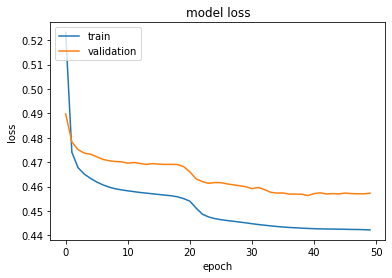

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The training dataset does not provide sufficient information to learn the problem, relative to the validation dataset used to evaluate it.

This is shown by the gap that remains between the two curves.

In [55]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([14113, 14018]))

In [56]:
print(14018/(14113+14018))

0.4983114713305606


880/880 [==============================] - 1s 1ms/step
The prediction loss threshold for 49% of outliers is 0.06


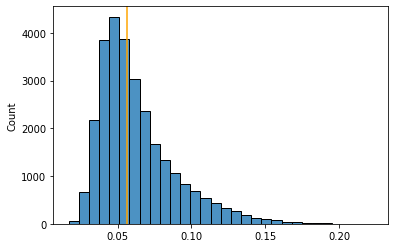

In [57]:
# Predict anomalies/outliers in the training dataset
prediction = autoencoder.predict(X_test)
# Get the mean absolute error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mae(prediction, X_test)
# Check the prediction loss threshold for 49% of outliers
loss_threshold = np.percentile(prediction_loss, 50)
print(f'The prediction loss threshold for 49% of outliers is {loss_threshold:.2f}')
# Visualize the threshold
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')

In [58]:
loss_threshold

0.05627790491019505

In [59]:
from sklearn.metrics import confusion_matrix


# Check the model performance at 2% threshold
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]
# Check the prediction performance
print(classification_report(y_test, threshold_prediction))

print ("")
print ("confusion_matrix: ")
print (confusion_matrix(y_test, threshold_prediction))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     14113
           1       0.75      0.75      0.75     14018

    accuracy                           0.75     28131
   macro avg       0.75      0.75      0.75     28131
weighted avg       0.75      0.75      0.75     28131


confusion_matrix: 
[[10591  3522]
 [ 3474 10544]]
